In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: LicenseRef-NvidiaProprietary
#
# NVIDIA CORPORATION, its affiliates and licensors retain all intellectual
# property and proprietary rights in and to this material, related
# documentation and any modifications thereto. Any use, reproduction,
# disclosure or distribution of this material and related documentation
# without an express license agreement from NVIDIA CORPORATION or
# its affiliates is strictly prohibited.

# SDXL 8-bit inference with TensorRT 

## Run end-to-end SDXL 8-bit inference with demoDiffusion

The [TensorRT repository](https://github.com/NVIDIA/TensorRT/tree/release/9.3/demo/Diffusion#faster-text-to-image-using-sdxl--int8-quantization-using-ammo) now hosts an end-to-end SDXL 8-bit inference pipeline, providing users with a ready-to-use solution to achieve optimized inference speed on Nvidia GPUs. You can simply run a single command as shown below to generate images with Percentile Quant and measure latency with demoDiffusion:

In [ ]:
%%bash
python demo_txt2img_xl.py "enchanted winter forest, soft diffuse light on a snow-filled day, serene nature scene, the forest is illuminated by the snow" --version xl-1.0 --onnx-dir onnx-sdxl --engine-dir engine-sdxl --int8 --quantization-level 3

Next, we provide an overview of the primary steps behind this command, including calibration, exportation, and TensorRT engine building. Please follow the [README](https://github.com/NVIDIA/TensorRT/tree/release/9.3/demo/Diffusion#setup) to setup the environment. 

## Calibration 

First, get the SDXL-1.0 base model from HuggingFace.

In [ ]:
import torch
from diffusers import DiffusionPipeline
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
base.to("cuda")

Next, let's load the calibration prompts:

In [ ]:
from utils import load_calib_prompts
batch_size = 2
cali_prompts = load_calib_prompts(batch_size, "./calib/calib_prompts.txt")

Then, create int8 quantization recipe and setup a few parameters:

In [ ]:
from utils import get_int8_config
quant_config = get_int8_config(
        base.unet, quant_level=3.0, alpha=0.8, percentile=1.0, num_inference_steps=50
    )

Now, apply quantization recipe and run calibration:

In [ ]:
import ammo.torch.quantization as atq
from utils import do_calibrate
def forward_loop(unet):
    base.unet = unet
    do_calibrate(
        base=base,
        calibration_prompts=cali_prompts,
        calib_size=384,
        n_steps=50,
    )
atq.quantize(base.unet, quant_config, forward_loop)

You can save the quantized model if needed:

In [ ]:
import ammo.torch.opt as ato
ato.save(base.unet, f"./base.unet.state_dict.int8.pt")

## Export ONNX 

After getting the SDXL UNet model quantized, we can export the ONNX model.

In [ ]:
# Prepare for ONNX export
from utils import filter_func, quantize_lvl
# Restore the quantized model if needed
# ato.restore(base.unet, 'base.unet.state_dict.int8.pt')
quantize_lvl(base.unet, quant_level=3.0)
atq.disable_quantizer(base.unet, filter_func)

# Export ONNX model
from onnx_utils.export import ammo_export_sd
base.unet.to(torch.float32).to("cpu")
ammo_export_sd(base, 'onnx_dir', "stabilityai/stable-diffusion-xl-base-1.0")

## Build TensorRT engine
With the int8 UNet ONNX model, you can then build the TensoRT engine according to [TensorRT documentation](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#trtexec-ovr).

In [ ]:
%%bash
trtexec --onnx=./onnx_dir/unet.onnx --shapes=sample:2x4x128x128,timestep:1,encoder_hidden_states:2x77x2048,text_embeds:2x1280,time_ids:2x6 --fp16 --int8 --builderOptimizationLevel=4 --saveEngine=unetxl.trt.plan

## Generate images and measure latency comparing fp16 and int8 in SDXL inference
You have gone through the steps to build int8 UNet engine for SDXL inference. 

Now, let's run the end-to-end pipeline to generate images and measure latency to compare fp16 baseline and our optimized int8 solution.
To save time, we will use pre-build TensorRT engines.  

Let's run the pipeline on the RTX 6000 Ada GPU with the fp16 model first.

In [34]:
%%bash
# Setup the environment
cd ~
export CUDA_VISIBLE_DEVICES=5
export PATH=$(pwd)/TensorRT-9.3.0.1/bin:$PATH
export LD_LIBRARY_PATH=$(pwd)/TensorRT-9.3.0.1/lib:$LD_LIBRARY_PATH

# Run inference with fp16 engine
cd /opt/zhiyu/projects/oss/demo/Diffusion
python demo_txt2img_xl.py "enchanted winter forest, soft diffuse light on a snow-filled day, serene nature scene, the forest is illuminated by the snow" --negative-prompt="normal quality, low quality, worst quality, low res, blurry, nsfw, nude" --version xl-1.0 --denoising-steps 50 --engine-dir engine-sdxl-fp16-gtc --seed 2946901


[I] Initializing TensorRT accelerated StableDiffusionXL txt2img pipeline
[I] Autoselected scheduler: Euler
[I] Load tokenizer pytorch model from: pytorch_model/xl-1.0/XL_BASE/tokenizer
[I] Load tokenizer pytorch model from: pytorch_model/xl-1.0/XL_BASE/tokenizer_2
Loading TensorRT engine: engine-sdxl-fp16-gtc/clip.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-fp16-gtc/clip.trt9.3.0.post12.dev1.plan
Loading TensorRT engine: engine-sdxl-fp16-gtc/clip2.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-fp16-gtc/clip2.trt9.3.0.post12.dev1.plan
Loading TensorRT engine: engine-sdxl-fp16-gtc/unetxl.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-fp16-gtc/unetxl.trt9.3.0.post12.dev1.plan
Loading TensorRT engine: engine-sdxl-fp16-gtc/vae.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-fp16-gtc/vae.trt9.3.0.post12.dev1.plan
[I] Warming up ..
[I] Running StableDiffusionXL pipeline
|-----------------|--------------|
|     Module      |   Latency  

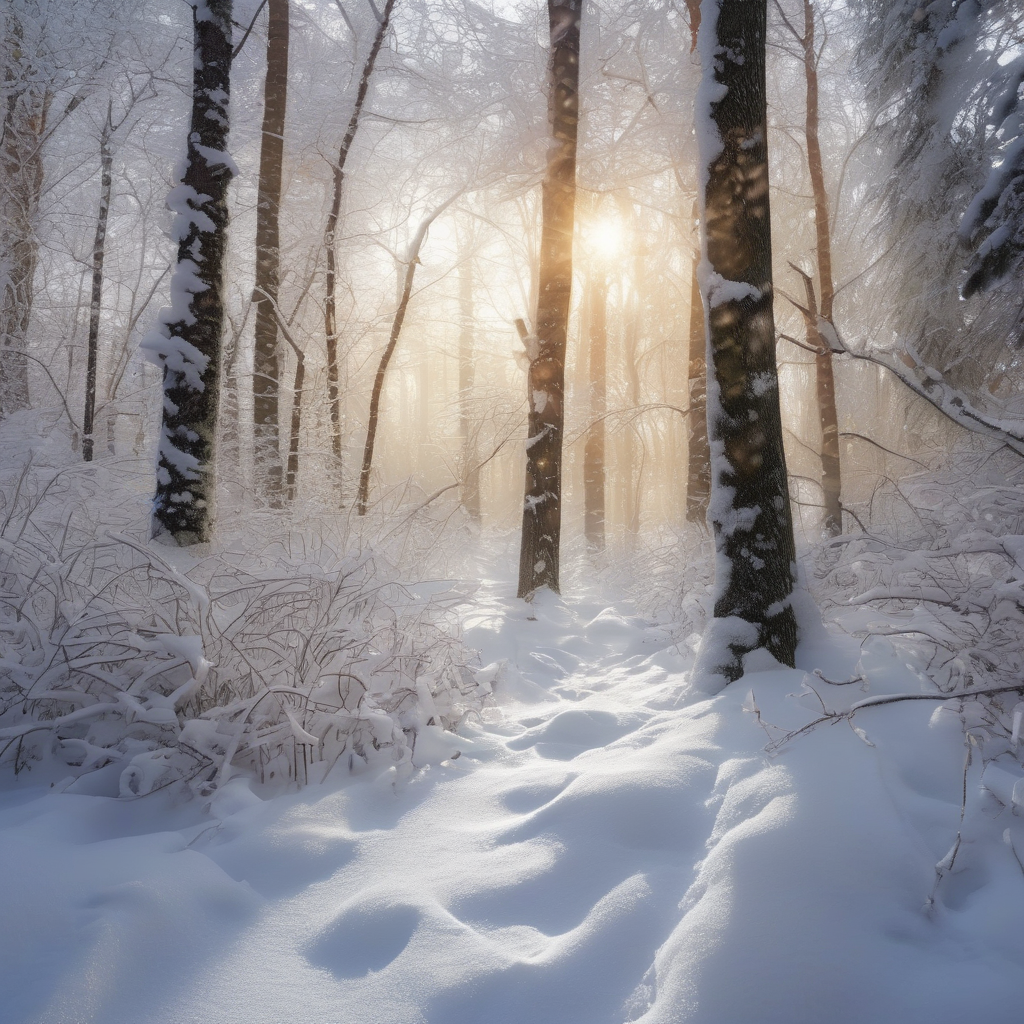

In [36]:
# Show the image generated by the fp16 model
from IPython.display import display, Image
from PIL import Image
image = Image.open("/opt/zhiyu/projects/oss/demo/Diffusion/output/xl_base-enchanted_-2946901-1-3445.png")
display(image)


Now let's see how our TensorRT SDXL int8 inference performs.

In [39]:
%%bash
# Setup the environment
cd ~
export CUDA_VISIBLE_DEVICES=6
export PATH=$(pwd)/TensorRT-9.3.0.1/bin:$PATH
export LD_LIBRARY_PATH=$(pwd)/TensorRT-9.3.0.1/lib:$LD_LIBRARY_PATH

# Run the int8 inference
cd /opt/zhiyu/projects/oss/demo/Diffusion
python demo_txt2img_xl.py "enchanted winter forest, soft diffuse light on a snow-filled day, serene nature scene, the forest is illuminated by the snow" --negative-prompt="normal quality, low quality, worst quality, low res, blurry, nsfw, nude" --version xl-1.0 --denoising-steps 50 --engine-dir engine-sdxl-int8-gtc --seed 2946901

[I] Initializing TensorRT accelerated StableDiffusionXL txt2img pipeline
[I] Autoselected scheduler: Euler
[I] Load tokenizer pytorch model from: pytorch_model/xl-1.0/XL_BASE/tokenizer
[I] Load tokenizer pytorch model from: pytorch_model/xl-1.0/XL_BASE/tokenizer_2
Loading TensorRT engine: engine-sdxl-int8-gtc/clip.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-int8-gtc/clip.trt9.3.0.post12.dev1.plan
Loading TensorRT engine: engine-sdxl-int8-gtc/clip2.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-int8-gtc/clip2.trt9.3.0.post12.dev1.plan
Loading TensorRT engine: engine-sdxl-int8-gtc/unetxl.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-int8-gtc/unetxl.trt9.3.0.post12.dev1.plan
[W] TensorRT was linked against cuDNN 8.9.6 but loaded cuDNN 8.9.3
Loading TensorRT engine: engine-sdxl-int8-gtc/vae.trt9.3.0.post12.dev1.plan
[I] Loading bytes from engine-sdxl-int8-gtc/vae.trt9.3.0.post12.dev1.plan
[I] Warming up ..
[I] Running StableDiffusionXL pipeline

This is great - we achieved **~1.5x** speedup!! Let's check the generated image.

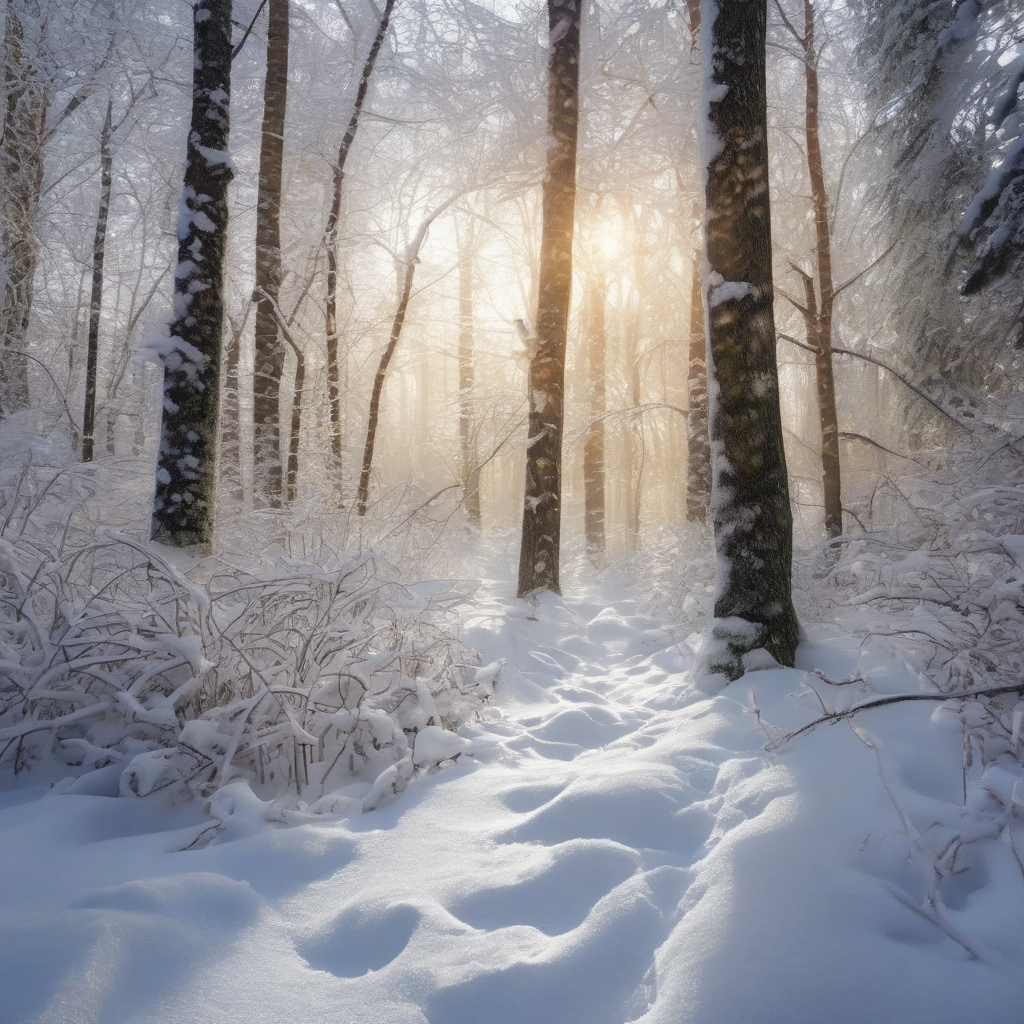

In [40]:
from IPython.display import display, Image
from PIL import Image
image = Image.open("/opt/zhiyu/projects/oss/demo/Diffusion/output/xl_base-enchanted_-2946901-1-6324.png")
display(image)

Nice - they look almost the same!

That's it. Thanks for attending our tutorial session at GTC 2024. 

To learn more about SDXL quantization with TensorRT, please check out our blogpost: [NVIDIA TensorRT Accelerates Stable Diffusion Nearly 2x Faster with 8-bit Post-Training Quantization](https://developer.nvidia.com/blog/tensorrt-accelerates-stable-diffusion-nearly-2x-faster-with-8-bit-post-training-quantization/?=&linkId=100000248434903)